# Отчёт о проделанной работе

## Введение

## Демонстрация работы класса

### Импорты

In [1]:
import warnings
import pandas as pd
from solution.solution import Solution
warnings.filterwarnings("ignore")

### Глобальные переменные

In [2]:
CALENDAR = pd.read_csv('../source/shop_sales_dates.csv')
DATA = pd.read_csv('../source/shop_sales.csv')
PRICES = pd.read_csv('../source/shop_sales_prices.csv')
STORES = sorted(DATA['store_id'].unique())

PERIODS = {"week": 7, "month": 30, "quarter": 90}

ROW = 5
COLUMN = 3

FEATURE_ENGINEERING_LAGS_OPTIONS = {
    "lag_count": 7,
    "seasonal_lag": 7,
    "seasonal_lag_count": 10,
    "mean_sizes": [7, 30],
}

SOLUTION = Solution(ROW, COLUMN, PERIODS)


### Препроцессинг (собираем фичи)

In [3]:
STORE = STORES[0]
SOLUTION.load(STORE, DATA, CALENDAR, PRICES)
SOLUTION.feature_engineering_lags(FEATURE_ENGINEERING_LAGS_OPTIONS)
SOLUTION.group_by("abs_day")

In [4]:
SOLUTION.working[SOLUTION.items[0]].head()

item_id store_id  cnt  CASHBACK_STORE_1  CASHBACK_STORE_2  \
abs_day                                                                  
0        STORE_1_064  STORE_1    0                 0                 0   
1        STORE_1_064  STORE_1    1                 0                 0   
2        STORE_1_064  STORE_1    0                 0                 0   
3        STORE_1_064  STORE_1    0                 0                 1   
4        STORE_1_064  STORE_1    0                 1                 1   

         CASHBACK_STORE_3  sell_price  EVENT_Chanukah End  \
abs_day                                                     
0                       0        2.54                   0   
1                       0        2.54                   0   
2                       0        2.54                   0   
3                       1        2.54                   0   
4                       0        2.54                   0   

         EVENT_OrthodoxEaster  EVENT_MemorialDay  ...  LAG_SEASONAL_3  \
abs_day                                           ...                   
0                           0                  0  ...             0.0   
1                           0                  0  ...             0.0   
2                           0                  0  ...             0.0   
3                           0                  0  ...             0.0   
4                           0                  0  ...             0.0   

         LAG_SEASONAL_4  LAG_SEASONAL_5  LAG_SEASONAL_6  LAG_SEASONAL_7  \
abs_day                                                                   
0                   0.0             0.0             0.0             0.0   
1                   0.0             0.0             0.0             0.0   
2                   0.0             0.0             0.0             0.0   
3                   0.0             0.0             0.0             0.0   
4                   0.0             0.0             0.0             0.0   

         LAG_SEASONAL_8  LAG_SEASONAL_9  LAG_SEASONAL_10  ROLLING_MEAN_7_LAG  \
abs_day                                                                        
0                   0.0             0.0              0.0                 0.0   
1                   0.0             0.0              0.0                 0.0   
2                   0.0             0.0              0.0                 0.0   
3                   0.0             0.0              0.0                 0.0   
4                   0.0             0.0              0.0                 0.0   

         ROLLING_MEAN_30_LAG  
abs_day                       
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  

[5 rows x 67 columns]

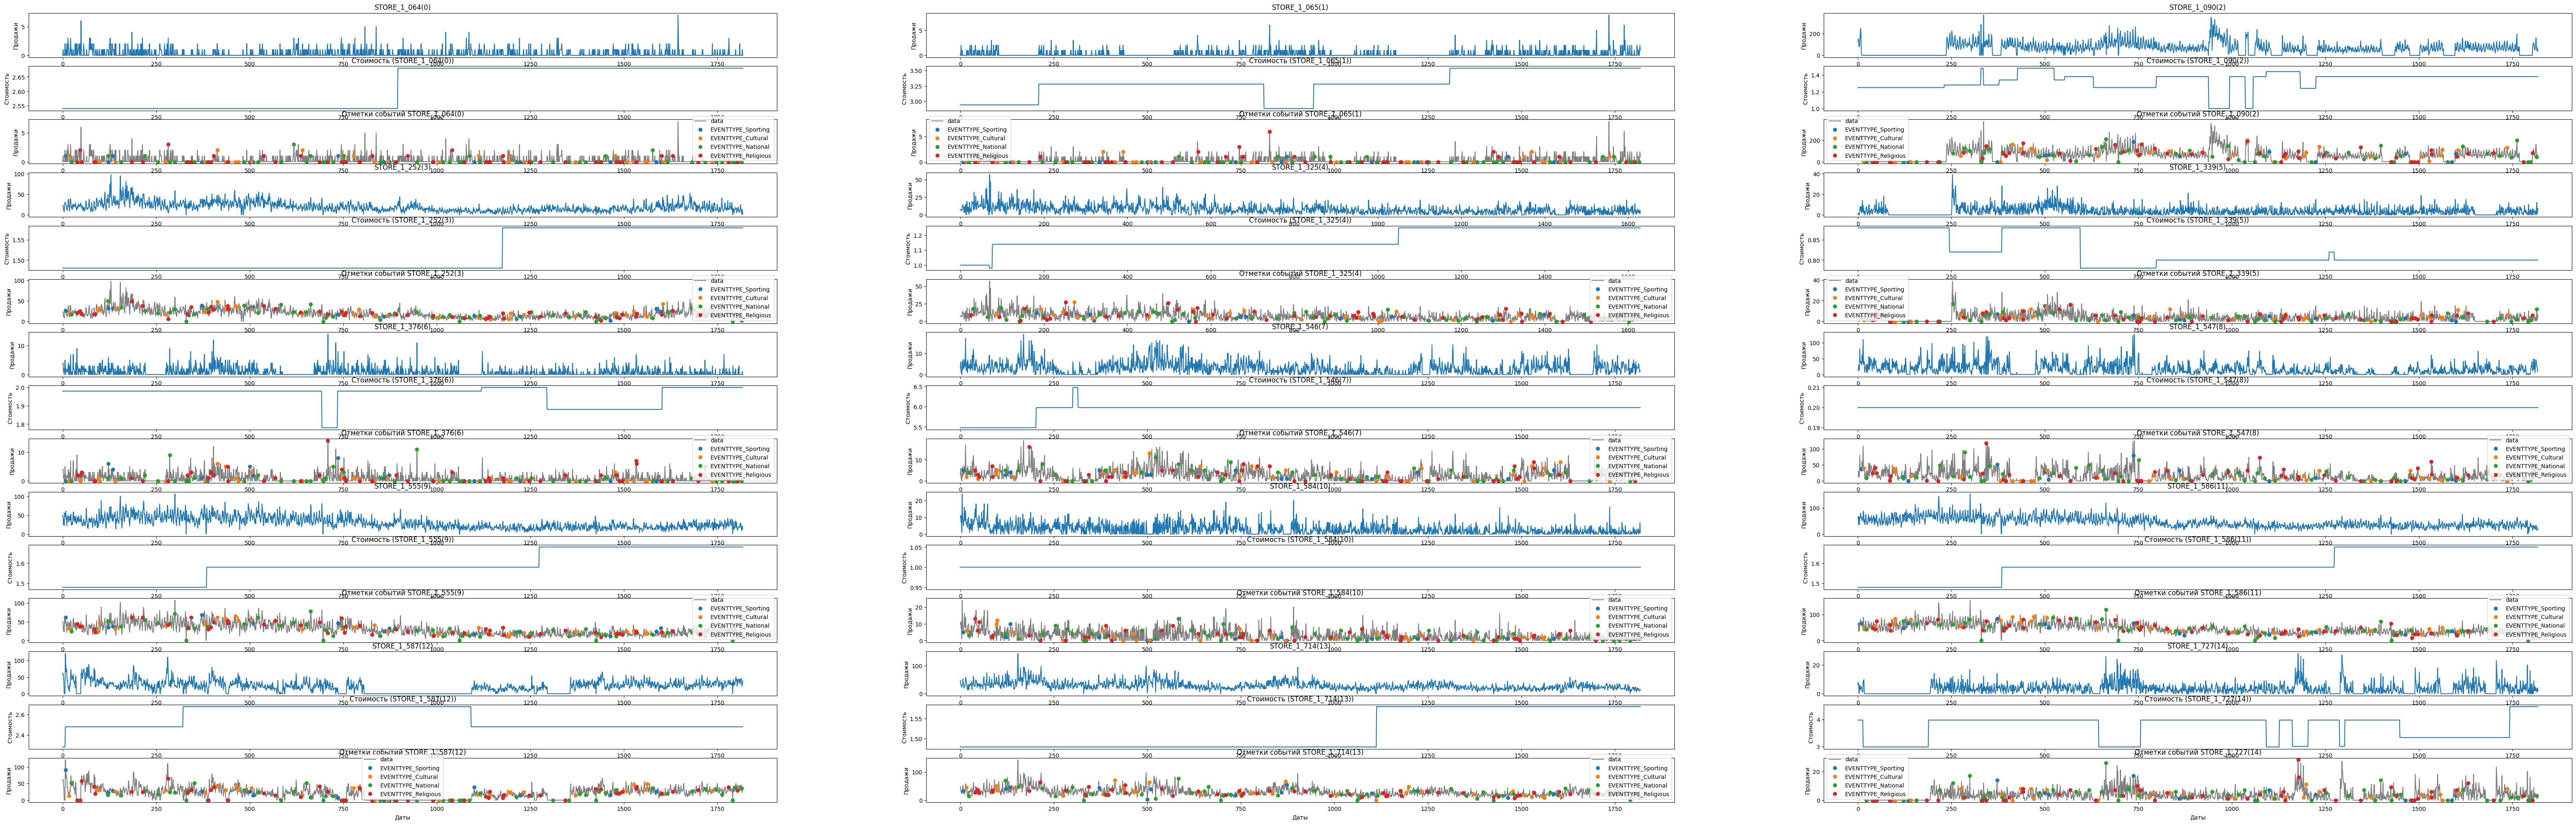

In [5]:
SOLUTION.visualize_dataset()

Разделим данные train/test для обучения на 3 сценария: 7 дней, 30 дней, 90 дней

In [6]:
SOLUTION.split_train_test()

### Анализ


#### Общий анализ
Оценим параметры train рядов:

In [7]:
SOLUTION.general_analyse()

Анализ (STORE_1_064(0))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  1.788548e-21  <=0.05    True       ✅
1        is_stationary              kpss  1.000000e-02   >0.05   False       ❌
2   no_autocorrelation    acorr_ljungbox  1.000000e+01     ==0   False       ❌
3  is_homoscedasticity  het_breuschpagan  1.973733e-02   >0.05   False       ❌
4         is_mean_zero       ttest_1samp  5.305732e-85   >0.05   False       ❌
5         is_normality           shapiro  6.229985e-55   >0.05   False       ❌
6                total                 -           NaN       -   False       ❌
Анализ (STORE_1_065(1))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  1.789872e-05  <=0.05    True       ✅
1        is_stationary              kpss  6.376277e-02   >0.05    True       ✅
2   no_autocorrelation    acorr_ljungbox  1.000000e+01     ==0   False       ❌
3  i

|Только последний ряд демонстрирует стационраность по обоим критериям. Все ряды гетероскедастичны.

#### Отчистка от нулей
По графикам рядов видно, что только для товаров под индексами 0, 1, 6, 7, 8 нули могут быть естественны, поэтому в остальных заменим нули предыдущим ненулевым значением. От всех нулей избавляться не будем, т. к. преобразование Йео-Джонсона этого не требует.

In [8]:
NATIVE_ZERO = {0, 1, 6, 7, 8}

SOLUTION.clean_zeros(NATIVE_ZERO)

STORE_1_090(2) zeroes: 451 -> 0
STORE_1_252(3) zeroes: 7 -> 0
STORE_1_325(4) zeroes: 125 -> 0
STORE_1_339(5) zeroes: 443 -> 0
STORE_1_555(9) zeroes: 5 -> 0
STORE_1_584(10) zeroes: 414 -> 0
STORE_1_586(11) zeroes: 5 -> 0
STORE_1_587(12) zeroes: 423 -> 0
STORE_1_714(13) zeroes: 6 -> 0
STORE_1_727(14) zeroes: 480 -> 0


#### Стабилизация дисперсии
Применим преобразование Йео-Джонсона для стабилизации дисперсии

In [9]:
SOLUTION.variance_stabilization()

### Стационарность
Почти у всех рядов adfuller проходит порог, а kpss - нет => ряды дифференцированно стационарные.
Продифференцируем с лагом 1 и с сезонным лагом 7 и посмотрим на результат.


In [10]:
LAG = 1
SOLUTION.do_diff(LAG)

Анализ (STORE_1_064(0))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  1.878979e-27  <=0.05    True       ✅
1        is_stationary              kpss  1.000000e-01   >0.05    True       ✅
2   no_autocorrelation    acorr_ljungbox  1.000000e+01     ==0   False       ❌
3  is_homoscedasticity  het_breuschpagan  1.181547e-03   >0.05   False       ❌
4         is_mean_zero       ttest_1samp  1.000000e+00   >0.05    True       ✅
5         is_normality           shapiro  3.540680e-44   >0.05   False       ❌
6                total                 -           NaN       -   False       ❌
Анализ (STORE_1_065(1))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  2.561418e-26  <=0.05    True       ✅
1        is_stationary              kpss  1.000000e-01   >0.05    True       ✅
2   no_autocorrelation    acorr_ljungbox  1.000000e+01     ==0   False       ❌
3  i

In [11]:
SEASONAL_LAG = 7
SOLUTION.do_diff_seasonal(SEASONAL_LAG)

Анализ (STORE_1_064(0))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  1.348332e-29  <=0.05    True       ✅
1        is_stationary              kpss  1.000000e-01   >0.05    True       ✅
2   no_autocorrelation    acorr_ljungbox  4.000000e+00     ==0   False       ❌
3  is_homoscedasticity  het_breuschpagan  3.901000e-01   >0.05    True       ✅
4         is_mean_zero       ttest_1samp  9.349592e-01   >0.05    True       ✅
5         is_normality           shapiro  1.576110e-43   >0.05   False       ❌
6                total                 -           NaN       -   False       ❌
Анализ (STORE_1_065(1))
                 title            method           val   check  result opinion
0        no_stationary          adfuller  1.460125e-25  <=0.05    True       ✅
1        is_stationary              kpss  1.000000e-01   >0.05    True       ✅
2   no_autocorrelation    acorr_ljungbox  4.000000e+00     ==0   False       ❌
3  i

Все ряды в результате дифференцирования на 1lag, 7lag по 1 разу стали стационарными.

#### Автокорреляционные и частичные автокорреляционные функции

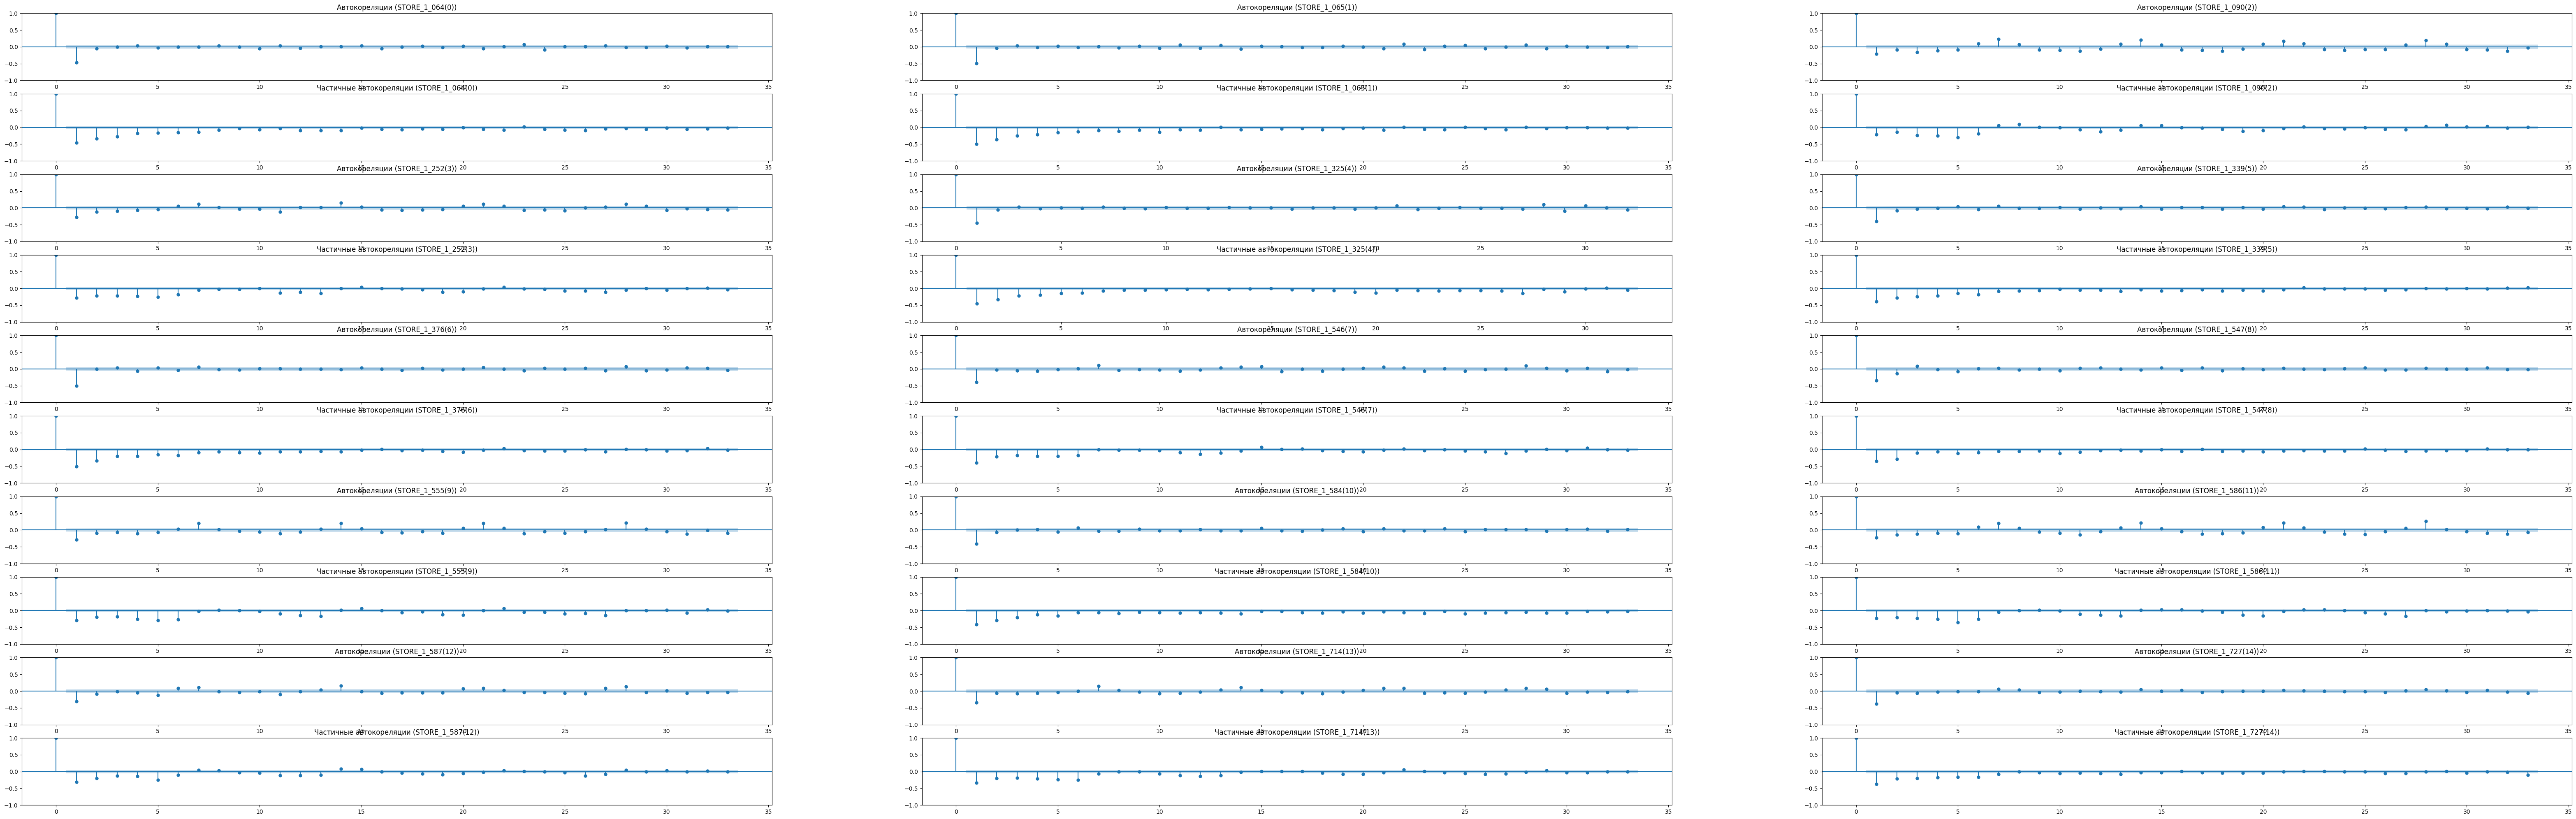

In [12]:
SOLUTION.visualize_acf_pacf(LAG)

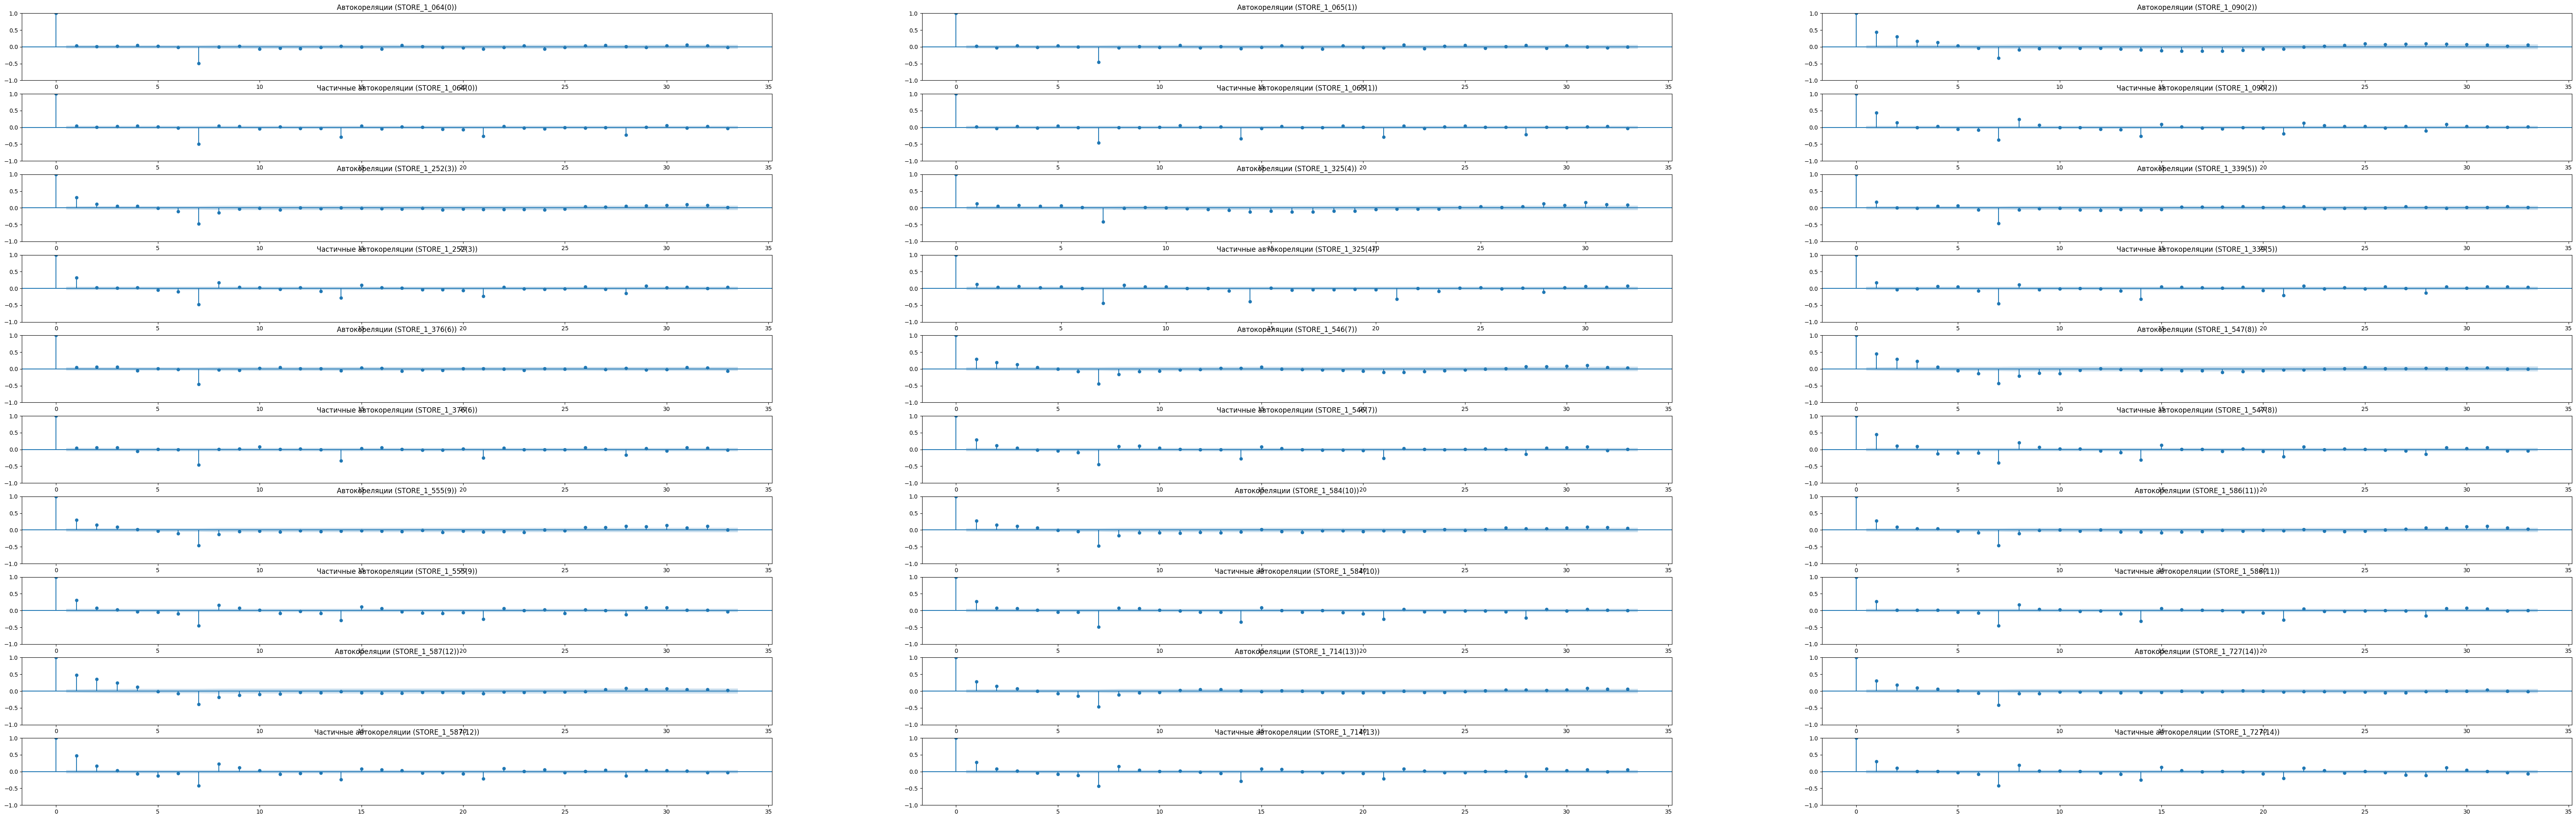

In [13]:
SOLUTION.visualize_acf_pacf(SEASONAL_LAG)

### Предсказания

#### Exponential Smoothing

In [14]:
EXPONENTIAL_SMOOTHING_SPACE = [
    {
        "name": "EXP_SMOOTH_esti",
        "trend": None,
        "seasonal": "add",
        "seasonal_periods": 7,
        "init": "estimated",
        "use_boxcox": False
    },
    {
        "name": "EXP_SMOOTH_heur",
        "trend": None,
        "seasonal": "add",
        "seasonal_periods": 7,
        "init": "heuristic",
        "use_boxcox": False
    },
]

#### Unobserved Components

In [15]:
UNOBSERVED_COMPONENTS_SPACE = [
    {
        "name": "UNOB_COMPS_deter",
        "level": 'deterministic constant',
        "trend": False,
        "seasonal": 7,
        "cycle": False,
        "irregular": True,
        "stochastic_level": False,
        "stochastic_trend": False,
        "damped_cycle": False,
    },
]

#### SARIMAX

In [16]:
SARIMAX_SPACE = {
    "p": [1, 6],
    "q": [1, 6],
    "P": [1, 6],
    "Q": [1, 6],
    "d": 1,
    "D": 1,
    "seasonal_period": 7
}

#### CATBOOST

In [17]:
FIELDS = ['CASHBACK_STORE_1', 'CASHBACK_STORE_2', 'CASHBACK_STORE_3', 'sell_price', 'EVENT_IndependenceDay', 'EVENT_Eid al-Fitr', 'EVENT_OrthodoxChristmas', 'EVENT_NBAFinalsStart', 'EVENT_Easter', "EVENT_Mother's day", 'EVENT_Cinco De Mayo', 'EVENT_ColumbusDay', 'EVENT_MartinLutherKingDay', 'EVENT_Halloween', 'EVENT_Chanukah End', 'EVENT_Pesach End', 'EVENT_Purim End', "EVENT_Father's day", 'EVENT_EidAlAdha', 'EVENT_NBAFinalsEnd', 'EVENT_Thanksgiving', 'EVENT_StPatricksDay', 'EVENT_ValentinesDay', 'EVENT_VeteransDay', 'EVENT_MemorialDay', 'EVENT_Ramadan starts', 'EVENT_SuperBowl', 'EVENT_OrthodoxEaster', 'EVENT_LentWeek2', 'EVENT_Christmas', 'EVENT_PresidentsDay', 'EVENT_LentStart', 'EVENT_LaborDay', 'EVENT_NewYear', 'EVENTTYPE_National', 'EVENTTYPE_Sporting', 'EVENTTYPE_Cultural', 'EVENTTYPE_Religious', 'WEEKDAY_Monday', 'WEEKDAY_Wednesday', 'WEEKDAY_Thursday', 'WEEKDAY_Saturday', 'WEEKDAY_Friday', 'WEEKDAY_Tuesday', 'WEEKDAY_Sunday', 'LAG_1', 'LAG_2', 'LAG_3', 'LAG_4', 'LAG_5', 'LAG_6', 'LAG_7', 'LAG_SEASONAL_1', 'LAG_SEASONAL_2', 'LAG_SEASONAL_3', 'LAG_SEASONAL_4', 'LAG_SEASONAL_5', 'LAG_SEASONAL_6', 'LAG_SEASONAL_7', 'LAG_SEASONAL_8', 'LAG_SEASONAL_9', 'LAG_SEASONAL_10', 'ROLLING_MEAN_7_LAG', 'ROLLING_MEAN_30_LAG']

In [18]:
SOLUTION.fit(EXPONENTIAL_SMOOTHING_SPACE, UNOBSERVED_COMPONENTS_SPACE, SARIMAX_SPACE, FIELDS)

fitting exponential smoothing models ...
fitting unobserved components models ...
fitting sarimax models ...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-818.285, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1788.262, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.40 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-1270.109, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-1920.997, Time=0.82 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.45 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-1478.925, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-2129.461, Time=0.87 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-1979.907, Time=0.59 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.76 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.21 sec
 ARIMA(3,1,0)(

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.034916
0:	learn: 0.6194467	test: 0.2639788	best: 0.2639788 (0)	total: 168ms	remaining: 2m 47s
100:	learn: 0.4917214	test: 0.2157494	best: 0.2138741 (92)	total: 280ms	remaining: 2.5s
200:	learn: 0.4093587	test: 0.1994384	best: 0.1976021 (198)	total: 396ms	remaining: 1.57s
300:	learn: 0.3369536	test: 0.1912623	best: 0.1894162 (281)	total: 535ms	remaining: 1.24s
400:	learn: 0.2713024	test: 0.1875705	best: 0.1849807 (350)	total: 659ms	remaining: 985ms
500:	learn: 0.2186725	test: 0.1807327	best: 0.1807327 (500)	total: 779ms	remaining: 776ms
600:	learn: 0.1818125	test: 0.1771916	best: 0.1763130 (596)	total: 918ms	remaining: 610ms
700:	learn: 0.1520819	test: 0.1765416	best: 0.1753800 (626)	total: 1.05s	remaining: 450ms
800:	learn: 0.1257651	test: 0.1741723	best: 0.1741405 (799)	total: 1.18s	remaining: 292ms
900:	learn: 0.1065946	test: 0.1701865	best: 0.1700295 (888)	total: 1.3s	remaining: 142ms
999:	learn: 0.0883942	test: 0.1697057	best: 0.1697057 (999)	total: 1.42s	rem

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 0.6892152	test: 2.9088785	best: 2.9088785 (0)	total: 1.7ms	remaining: 1.69s
100:	learn: 0.5202566	test: 2.8885363	best: 2.8714317 (49)	total: 142ms	remaining: 1.27s
200:	learn: 0.4148363	test: 2.9007967	best: 2.8714317 (49)	total: 279ms	remaining: 1.11s
300:	learn: 0.3068848	test: 2.8864496	best: 2.8714317 (49)	total: 421ms	remaining: 977ms
400:	learn: 0.2267004	test: 2.8883717	best: 2.8714317 (49)	total: 563ms	remaining: 840ms
500:	learn: 0.1698358	test: 2.8916639	best: 2.8714317 (49)	total: 702ms	remaining: 699ms
600:	learn: 0.1341414	test: 2.8961955	best: 2.8714317 (49)	total: 842ms	remaining: 559ms
700:	learn: 0.1095319	test: 2.8993816	best: 2.8714317 (49)	total: 1.1s	remaining: 469ms
800:	learn: 0.0889746	test: 2.8987124	best: 2.8714317 (49)	total: 1.24s	remaining: 309ms
900:	learn: 0.0739424	test: 2.8970521	best: 2.8714317 (49)	total: 1.38s	remaining: 152ms
999:	learn: 0.0629301	test: 2.8985209	best: 2.8714317 (49)	total: 1.54s	remaining: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 26.7432587	test: 35.3130386	best: 35.3130386 (0)	total: 5.04ms	remaining: 5.04s
100:	learn: 12.8563864	test: 21.0119871	best: 20.9886490 (99)	total: 445ms	remaining: 3.96s
200:	learn: 8.6268670	test: 19.4796784	best: 19.4796784 (200)	total: 854ms	remaining: 3.4s
300:	learn: 5.4057113	test: 19.4918697	best: 19.4481140 (204)	total: 1.28s	remaining: 2.97s
400:	learn: 3.5425847	test: 19.2882421	best: 19.2882421 (400)	total: 1.71s	remaining: 2.55s
500:	learn: 2.3819483	test: 19.0834992	best: 19.0610639 (492)	total: 2.13s	remaining: 2.12s
600:	learn: 1.6014138	test: 18.9430588	best: 18.9377084 (591)	total: 2.54s	remaining: 1.69s
700:	learn: 1.1229119	test: 18.8299383	best: 18.8298743 (697)	total: 2.98s	remaining: 1.27s
800:	learn: 0.7650003	test: 18.7611947	best: 18.7582949 (796)	total: 3.4s	remaining: 844ms
900:	learn: 0.5440757	test: 18.7157385	best: 18.7143688 (896)	total: 3.83s	remaining: 420ms
999:	learn: 0.3854562	test: 18.6733087	best: 18.667465

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 8.5534231	test: 9.2670998	best: 9.2670998 (0)	total: 3.22ms	remaining: 3.22s
100:	learn: 4.8762477	test: 10.3832230	best: 9.2670998 (0)	total: 395ms	remaining: 3.51s
200:	learn: 3.2192769	test: 10.7007919	best: 9.2670998 (0)	total: 795ms	remaining: 3.16s
300:	learn: 2.0261830	test: 11.0144372	best: 9.2670998 (0)	total: 1.3s	remaining: 3.02s
400:	learn: 1.1525440	test: 11.1379395	best: 9.2670998 (0)	total: 1.69s	remaining: 2.53s
500:	learn: 0.7226761	test: 11.1841847	best: 9.2670998 (0)	total: 2.07s	remaining: 2.06s
600:	learn: 0.4487222	test: 11.1435663	best: 9.2670998 (0)	total: 2.44s	remaining: 1.62s
700:	learn: 0.2903934	test: 11.1739765	best: 9.2670998 (0)	total: 2.81s	remaining: 1.2s
800:	learn: 0.1883909	test: 11.1933450	best: 9.2670998 (0)	total: 3.29s	remaining: 817ms
900:	learn: 0.1192444	test: 11.1998659	best: 9.2670998 (0)	total: 3.69s	remaining: 405ms
999:	learn: 0.0787455	test: 11.2019808	best: 9.2670998 (0)	total: 4.07s	remaining: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.9822385	test: 4.2537215	best: 4.2537215 (0)	total: 2.88ms	remaining: 2.87s
100:	learn: 2.3772034	test: 4.0778866	best: 4.0778866 (100)	total: 244ms	remaining: 2.17s
200:	learn: 1.4639984	test: 4.1307379	best: 4.0437036 (110)	total: 440ms	remaining: 1.75s
300:	learn: 0.8962983	test: 3.9400586	best: 3.9399821 (299)	total: 636ms	remaining: 1.48s
400:	learn: 0.5758935	test: 3.9032667	best: 3.9002844 (399)	total: 832ms	remaining: 1.24s
500:	learn: 0.3789004	test: 3.8514663	best: 3.8509721 (497)	total: 1.05s	remaining: 1.04s
600:	learn: 0.2277938	test: 3.8311153	best: 3.8311153 (600)	total: 1.24s	remaining: 825ms
700:	learn: 0.1382843	test: 3.8379100	best: 3.8242740 (630)	total: 1.48s	remaining: 630ms
800:	learn: 0.0855458	test: 3.8421866	best: 3.8242740 (630)	total: 1.68s	remaining: 418ms
900:	learn: 0.0502057	test: 3.8445664	best: 3.8242740 (630)	total: 1.91s	remaining: 210ms
999:	learn: 0.0301391	test: 3.8449711	best: 3.8242740 (630)	total: 2.13s	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.9262956	test: 2.0575693	best: 2.0575693 (0)	total: 2.13ms	remaining: 2.13s
100:	learn: 1.8914171	test: 1.7355174	best: 1.7355174 (100)	total: 196ms	remaining: 1.75s
200:	learn: 1.1694538	test: 1.7482987	best: 1.7147501 (105)	total: 371ms	remaining: 1.48s
300:	learn: 0.6549390	test: 1.6963705	best: 1.6906332 (282)	total: 582ms	remaining: 1.35s
400:	learn: 0.3572686	test: 1.6386069	best: 1.6375769 (398)	total: 755ms	remaining: 1.13s
500:	learn: 0.1964041	test: 1.6063359	best: 1.6058990 (499)	total: 938ms	remaining: 935ms
600:	learn: 0.1126102	test: 1.5812158	best: 1.5811057 (592)	total: 1.12s	remaining: 747ms
700:	learn: 0.0658586	test: 1.5724180	best: 1.5717203 (696)	total: 1.3s	remaining: 556ms
800:	learn: 0.0382950	test: 1.5653720	best: 1.5651406 (790)	total: 1.5s	remaining: 373ms
900:	learn: 0.0231451	test: 1.5642080	best: 1.5639675 (883)	total: 1.7s	remaining: 187ms
999:	learn: 0.0137643	test: 1.5619067	best: 1.5618093 (978)	total: 1.95s	rem

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 1.1808164	test: 0.5977405	best: 0.5977405 (0)	total: 1.57ms	remaining: 1.56s
100:	learn: 0.9559985	test: 0.4942835	best: 0.4942835 (100)	total: 138ms	remaining: 1.23s
200:	learn: 0.7363732	test: 0.5052938	best: 0.4942835 (100)	total: 273ms	remaining: 1.09s
300:	learn: 0.5347567	test: 0.4671769	best: 0.4648701 (279)	total: 416ms	remaining: 966ms
400:	learn: 0.3829852	test: 0.4516445	best: 0.4493098 (390)	total: 565ms	remaining: 844ms
500:	learn: 0.2782739	test: 0.4523020	best: 0.4444272 (486)	total: 705ms	remaining: 702ms
600:	learn: 0.2137588	test: 0.4717002	best: 0.4444272 (486)	total: 841ms	remaining: 558ms
700:	learn: 0.1634835	test: 0.4814959	best: 0.4444272 (486)	total: 995ms	remaining: 425ms
800:	learn: 0.1279032	test: 0.4926945	best: 0.4444272 (486)	total: 1.16s	remaining: 289ms
900:	learn: 0.0991723	test: 0.4946990	best: 0.4444272 (486)	total: 1.3s	remaining: 143ms
999:	learn: 0.0762646	test: 0.4978564	best: 0.4444272 (486)	total: 1.44s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 2.6356555	test: 2.4423444	best: 2.4423444 (0)	total: 2.16ms	remaining: 2.16s
100:	learn: 1.5574033	test: 2.5256157	best: 2.4423444 (0)	total: 216ms	remaining: 1.92s
200:	learn: 1.0301293	test: 2.5299081	best: 2.4423444 (0)	total: 416ms	remaining: 1.65s
300:	learn: 0.6494142	test: 2.5793624	best: 2.4423444 (0)	total: 617ms	remaining: 1.43s
400:	learn: 0.4405651	test: 2.6047073	best: 2.4423444 (0)	total: 822ms	remaining: 1.23s
500:	learn: 0.2969749	test: 2.5849488	best: 2.4423444 (0)	total: 1.04s	remaining: 1.04s
600:	learn: 0.2046207	test: 2.5879241	best: 2.4423444 (0)	total: 1.25s	remaining: 827ms
700:	learn: 0.1457256	test: 2.5851329	best: 2.4423444 (0)	total: 1.46s	remaining: 623ms
800:	learn: 0.1033305	test: 2.5850590	best: 2.4423444 (0)	total: 1.66s	remaining: 413ms
900:	learn: 0.0747192	test: 2.5842901	best: 2.4423444 (0)	total: 1.86s	remaining: 205ms
999:	learn: 0.0537763	test: 2.5838848	best: 2.4423444 (0)	total: 2.07s	remaining: 0us

best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 11.2490104	test: 8.2897468	best: 8.2897468 (0)	total: 2.87ms	remaining: 2.87s
100:	learn: 6.5985338	test: 7.0981517	best: 6.8281381 (75)	total: 300ms	remaining: 2.67s
200:	learn: 4.8381629	test: 7.0354029	best: 6.8281381 (75)	total: 588ms	remaining: 2.34s
300:	learn: 3.3504404	test: 7.3979387	best: 6.8281381 (75)	total: 875ms	remaining: 2.03s
400:	learn: 2.3129250	test: 7.5449408	best: 6.8281381 (75)	total: 1.3s	remaining: 1.95s
500:	learn: 1.6084579	test: 7.6948660	best: 6.8281381 (75)	total: 1.61s	remaining: 1.6s
600:	learn: 1.0986043	test: 7.7896238	best: 6.8281381 (75)	total: 1.9s	remaining: 1.26s
700:	learn: 0.7449230	test: 7.8065232	best: 6.8281381 (75)	total: 2.21s	remaining: 942ms
800:	learn: 0.5117517	test: 7.8168760	best: 6.8281381 (75)	total: 2.52s	remaining: 625ms
900:	learn: 0.3584854	test: 7.8187163	best: 6.8281381 (75)	total: 2.8s	remaining: 308ms
999:	learn: 0.2500518	test: 7.8182269	best: 6.8281381 (75)	total: 3.1s	remaining: 0us

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 7.1175733	test: 7.8374643	best: 7.8374643 (0)	total: 2.76ms	remaining: 2.76s
100:	learn: 4.3329291	test: 6.6630446	best: 6.6179755 (97)	total: 259ms	remaining: 2.31s
200:	learn: 3.0329248	test: 6.5129513	best: 6.4396381 (151)	total: 513ms	remaining: 2.04s
300:	learn: 1.8420820	test: 6.5258551	best: 6.4040432 (233)	total: 757ms	remaining: 1.76s
400:	learn: 1.1511050	test: 6.5165545	best: 6.4040432 (233)	total: 1.01s	remaining: 1.51s
500:	learn: 0.7370800	test: 6.4864251	best: 6.4040432 (233)	total: 1.27s	remaining: 1.26s
600:	learn: 0.4680415	test: 6.4645471	best: 6.4040432 (233)	total: 1.53s	remaining: 1.01s
700:	learn: 0.3006254	test: 6.4611260	best: 6.4040432 (233)	total: 1.77s	remaining: 756ms
800:	learn: 0.2028267	test: 6.4490517	best: 6.4040432 (233)	total: 2.05s	remaining: 509ms
900:	learn: 0.1363992	test: 6.4454145	best: 6.4040432 (233)	total: 2.3s	remaining: 252ms
999:	learn: 0.0917163	test: 6.4383017	best: 6.4040432 (233)	total: 2.56s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 1.8978109	test: 2.4669581	best: 2.4669581 (0)	total: 2.06ms	remaining: 2.06s
100:	learn: 1.1934744	test: 2.3285140	best: 2.3112034 (94)	total: 185ms	remaining: 1.65s
200:	learn: 0.8088294	test: 2.4064446	best: 2.3112034 (94)	total: 355ms	remaining: 1.41s
300:	learn: 0.5430380	test: 2.3897007	best: 2.3112034 (94)	total: 522ms	remaining: 1.21s
400:	learn: 0.3303079	test: 2.3970456	best: 2.3112034 (94)	total: 691ms	remaining: 1.03s
500:	learn: 0.1902365	test: 2.3737000	best: 2.3112034 (94)	total: 861ms	remaining: 858ms
600:	learn: 0.1201055	test: 2.3650723	best: 2.3112034 (94)	total: 1.05s	remaining: 695ms
700:	learn: 0.0719487	test: 2.3660362	best: 2.3112034 (94)	total: 1.22s	remaining: 520ms
800:	learn: 0.0467217	test: 2.3683749	best: 2.3112034 (94)	total: 1.42s	remaining: 352ms
900:	learn: 0.0323866	test: 2.3683031	best: 2.3112034 (94)	total: 1.6s	remaining: 176ms
999:	learn: 0.0207290	test: 2.3702642	best: 2.3112034 (94)	total: 1.77s	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 10.6515682	test: 9.7255035	best: 9.7255035 (0)	total: 3.5ms	remaining: 3.5s
100:	learn: 6.3645118	test: 8.4952161	best: 8.4342192 (81)	total: 322ms	remaining: 2.87s
200:	learn: 4.4697918	test: 8.6270281	best: 8.4318138 (158)	total: 648ms	remaining: 2.58s
300:	learn: 2.8372004	test: 9.0150501	best: 8.4318138 (158)	total: 962ms	remaining: 2.23s
400:	learn: 1.8470922	test: 9.1244484	best: 8.4318138 (158)	total: 1.29s	remaining: 1.93s
500:	learn: 1.0884117	test: 9.1892275	best: 8.4318138 (158)	total: 1.66s	remaining: 1.65s
600:	learn: 0.6755123	test: 9.2245956	best: 8.4318138 (158)	total: 1.98s	remaining: 1.31s
700:	learn: 0.4297695	test: 9.2584505	best: 8.4318138 (158)	total: 2.31s	remaining: 985ms
800:	learn: 0.2761361	test: 9.2674345	best: 8.4318138 (158)	total: 2.69s	remaining: 669ms
900:	learn: 0.1896848	test: 9.2708330	best: 8.4318138 (158)	total: 3.02s	remaining: 331ms
999:	learn: 0.1262005	test: 9.2826223	best: 8.4318138 (158)	total: 3.33s	re

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 9.9869533	test: 6.8674574	best: 6.8674574 (0)	total: 3.49ms	remaining: 3.48s
100:	learn: 5.1765931	test: 2.6211590	best: 2.6211590 (100)	total: 337ms	remaining: 3s
200:	learn: 3.1033029	test: 2.5143019	best: 2.4497676 (115)	total: 664ms	remaining: 2.64s
300:	learn: 2.1557794	test: 2.6230029	best: 2.4497676 (115)	total: 993ms	remaining: 2.31s
400:	learn: 1.5119514	test: 2.5426506	best: 2.4497676 (115)	total: 1.33s	remaining: 1.99s
500:	learn: 1.0574978	test: 2.5161527	best: 2.4497676 (115)	total: 1.66s	remaining: 1.65s
600:	learn: 0.6721162	test: 2.4822540	best: 2.4497676 (115)	total: 1.99s	remaining: 1.32s
700:	learn: 0.4376434	test: 2.4926418	best: 2.4497676 (115)	total: 2.33s	remaining: 993ms
800:	learn: 0.2959409	test: 2.4899933	best: 2.4497676 (115)	total: 2.67s	remaining: 664ms
900:	learn: 0.2100753	test: 2.4921611	best: 2.4497676 (115)	total: 3.01s	remaining: 330ms
999:	learn: 0.1471133	test: 2.4889765	best: 2.4497676 (115)	total: 3.32s	rem

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 8.5313846	test: 7.0376938	best: 7.0376938 (0)	total: 3.03ms	remaining: 3.03s
100:	learn: 5.3484259	test: 6.8989371	best: 6.8989371 (100)	total: 290ms	remaining: 2.58s
200:	learn: 3.7996117	test: 6.7916822	best: 6.6594322 (164)	total: 591ms	remaining: 2.35s
300:	learn: 2.6320184	test: 7.2717229	best: 6.6594322 (164)	total: 878ms	remaining: 2.04s
400:	learn: 1.7134304	test: 7.4032551	best: 6.6594322 (164)	total: 1.19s	remaining: 1.78s
500:	learn: 1.0642866	test: 7.4609159	best: 6.6594322 (164)	total: 1.49s	remaining: 1.48s
600:	learn: 0.6881922	test: 7.4722863	best: 6.6594322 (164)	total: 1.78s	remaining: 1.18s
700:	learn: 0.4448848	test: 7.4693126	best: 6.6594322 (164)	total: 2.07s	remaining: 885ms
800:	learn: 0.2756740	test: 7.4942704	best: 6.6594322 (164)	total: 2.37s	remaining: 590ms
900:	learn: 0.1772664	test: 7.4930713	best: 6.6594322 (164)	total: 2.7s	remaining: 297ms
999:	learn: 0.1182967	test: 7.4904727	best: 6.6594322 (164)	total: 3s	rema

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043469
0:	learn: 3.7730583	test: 2.8550598	best: 2.8550598 (0)	total: 3.44ms	remaining: 3.44s
100:	learn: 2.3795245	test: 1.9678482	best: 1.9678482 (100)	total: 282ms	remaining: 2.51s
200:	learn: 1.5053036	test: 1.9598168	best: 1.9295869 (188)	total: 542ms	remaining: 2.15s
300:	learn: 0.9742700	test: 2.0067945	best: 1.9295869 (188)	total: 909ms	remaining: 2.11s
400:	learn: 0.6362666	test: 1.9794583	best: 1.9295869 (188)	total: 1.22s	remaining: 1.82s
500:	learn: 0.4316436	test: 1.9948204	best: 1.9295869 (188)	total: 1.53s	remaining: 1.52s
600:	learn: 0.2988906	test: 2.0125411	best: 1.9295869 (188)	total: 1.85s	remaining: 1.23s
700:	learn: 0.2139460	test: 2.0159275	best: 1.9295869 (188)	total: 2.18s	remaining: 932ms
800:	learn: 0.1532105	test: 2.0179436	best: 1.9295869 (188)	total: 2.63s	remaining: 653ms
900:	learn: 0.1129565	test: 2.0174794	best: 1.9295869 (188)	total: 2.89s	remaining: 318ms
999:	learn: 0.0830415	test: 2.0138656	best: 1.9295869 (188)	total: 3.15s	

In [19]:
SOLUTION.predict()

predicting exponential smoothing models ...
predicting unobserved components models ...
predicting sarimax models ...
predicting catboost models ...


### Отменяем внесённые изменения 

#### Отменяем дифференцирование

In [20]:
SOLUTION.predicts_reverse_diff()

#### Отменяем преобразование Йео-Джонсона

In [21]:
SOLUTION.predicts_reverse_yeojohnson()

### Скоринг

Результаты на week: 


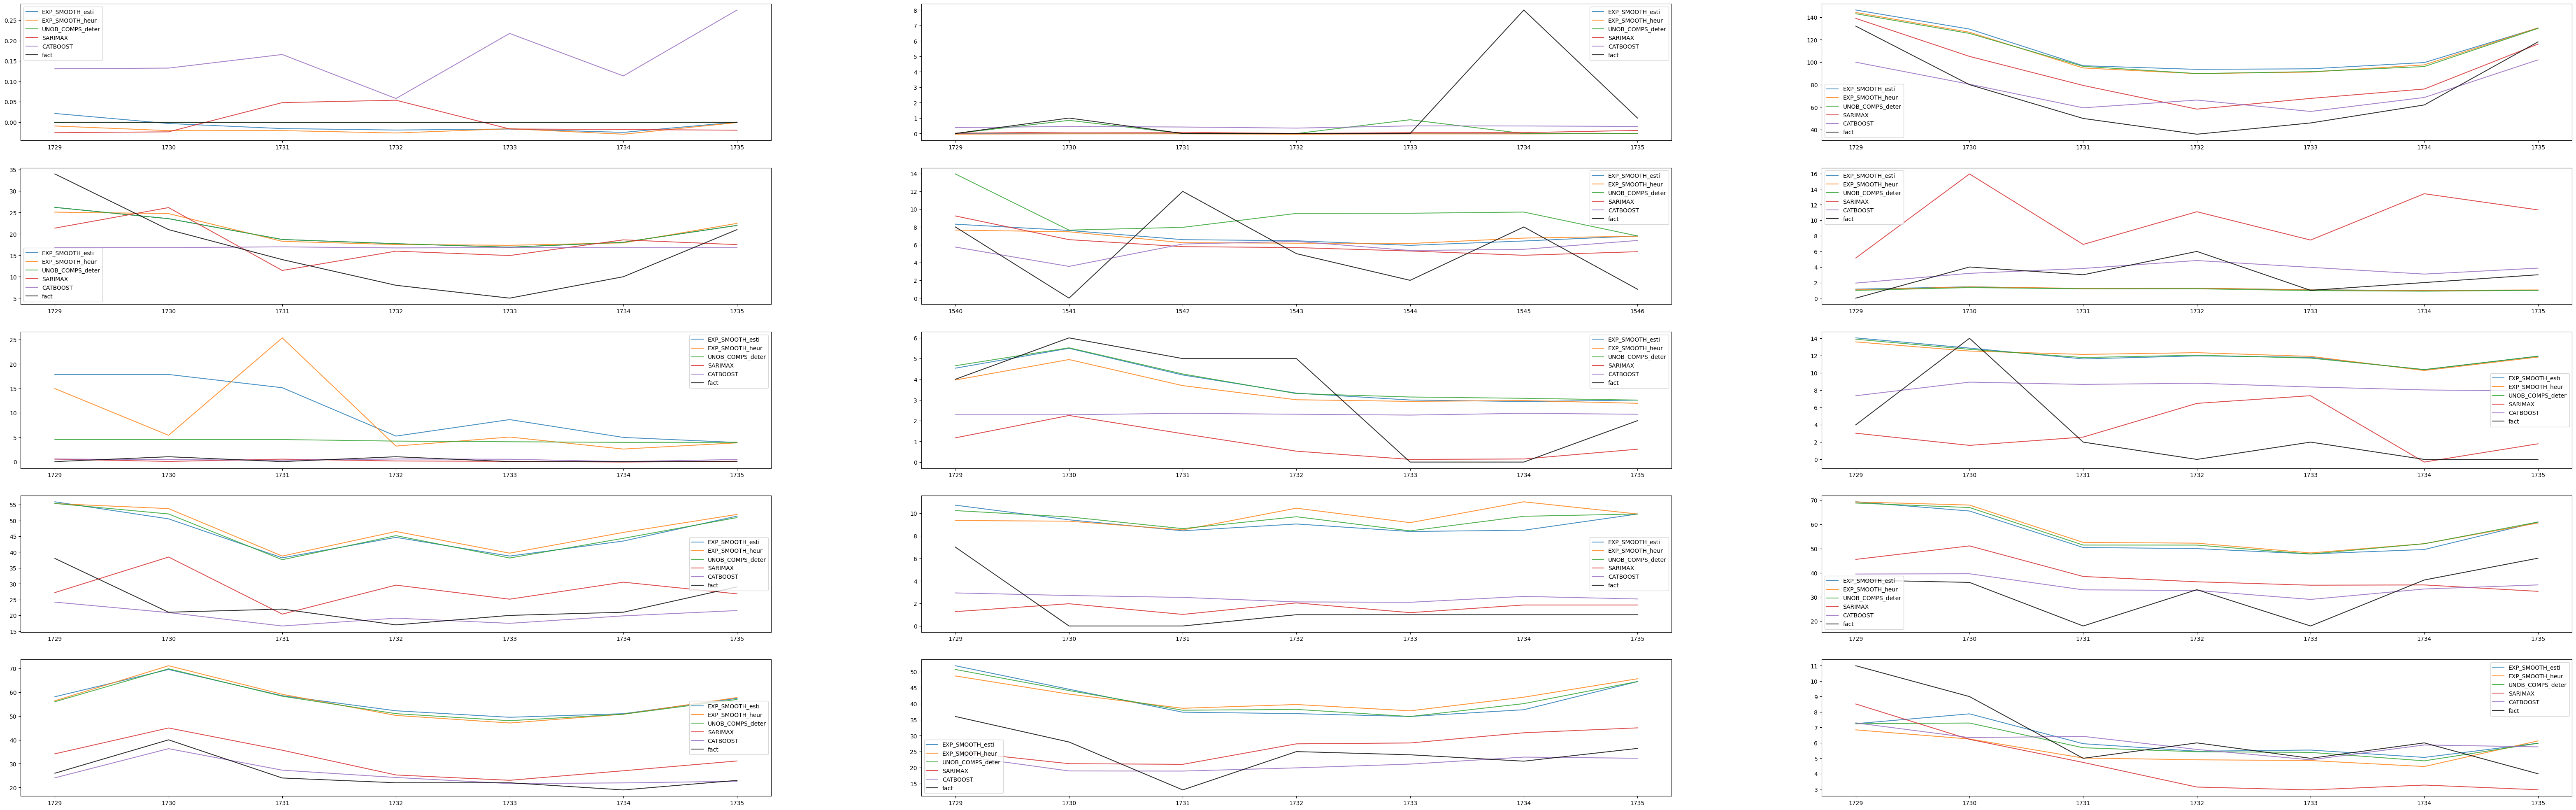

Результаты на month: 


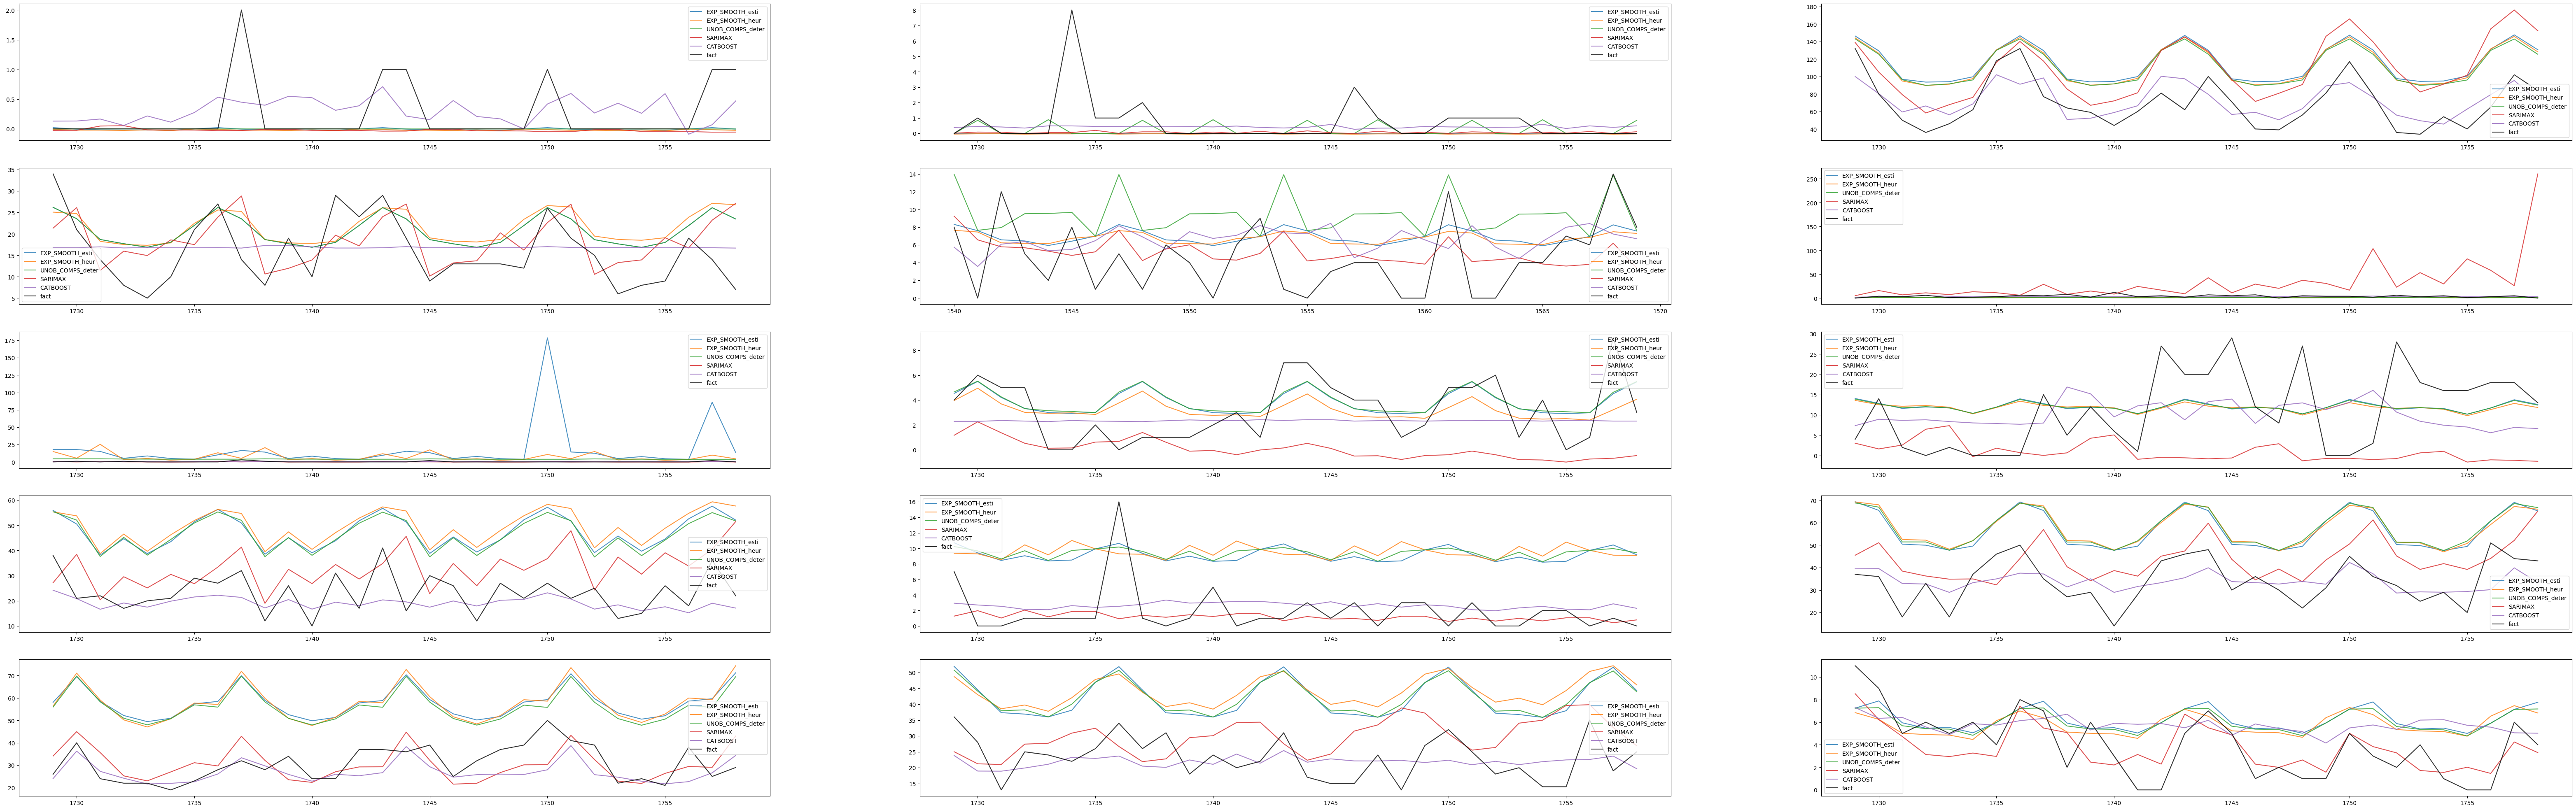

Результаты на quarter: 


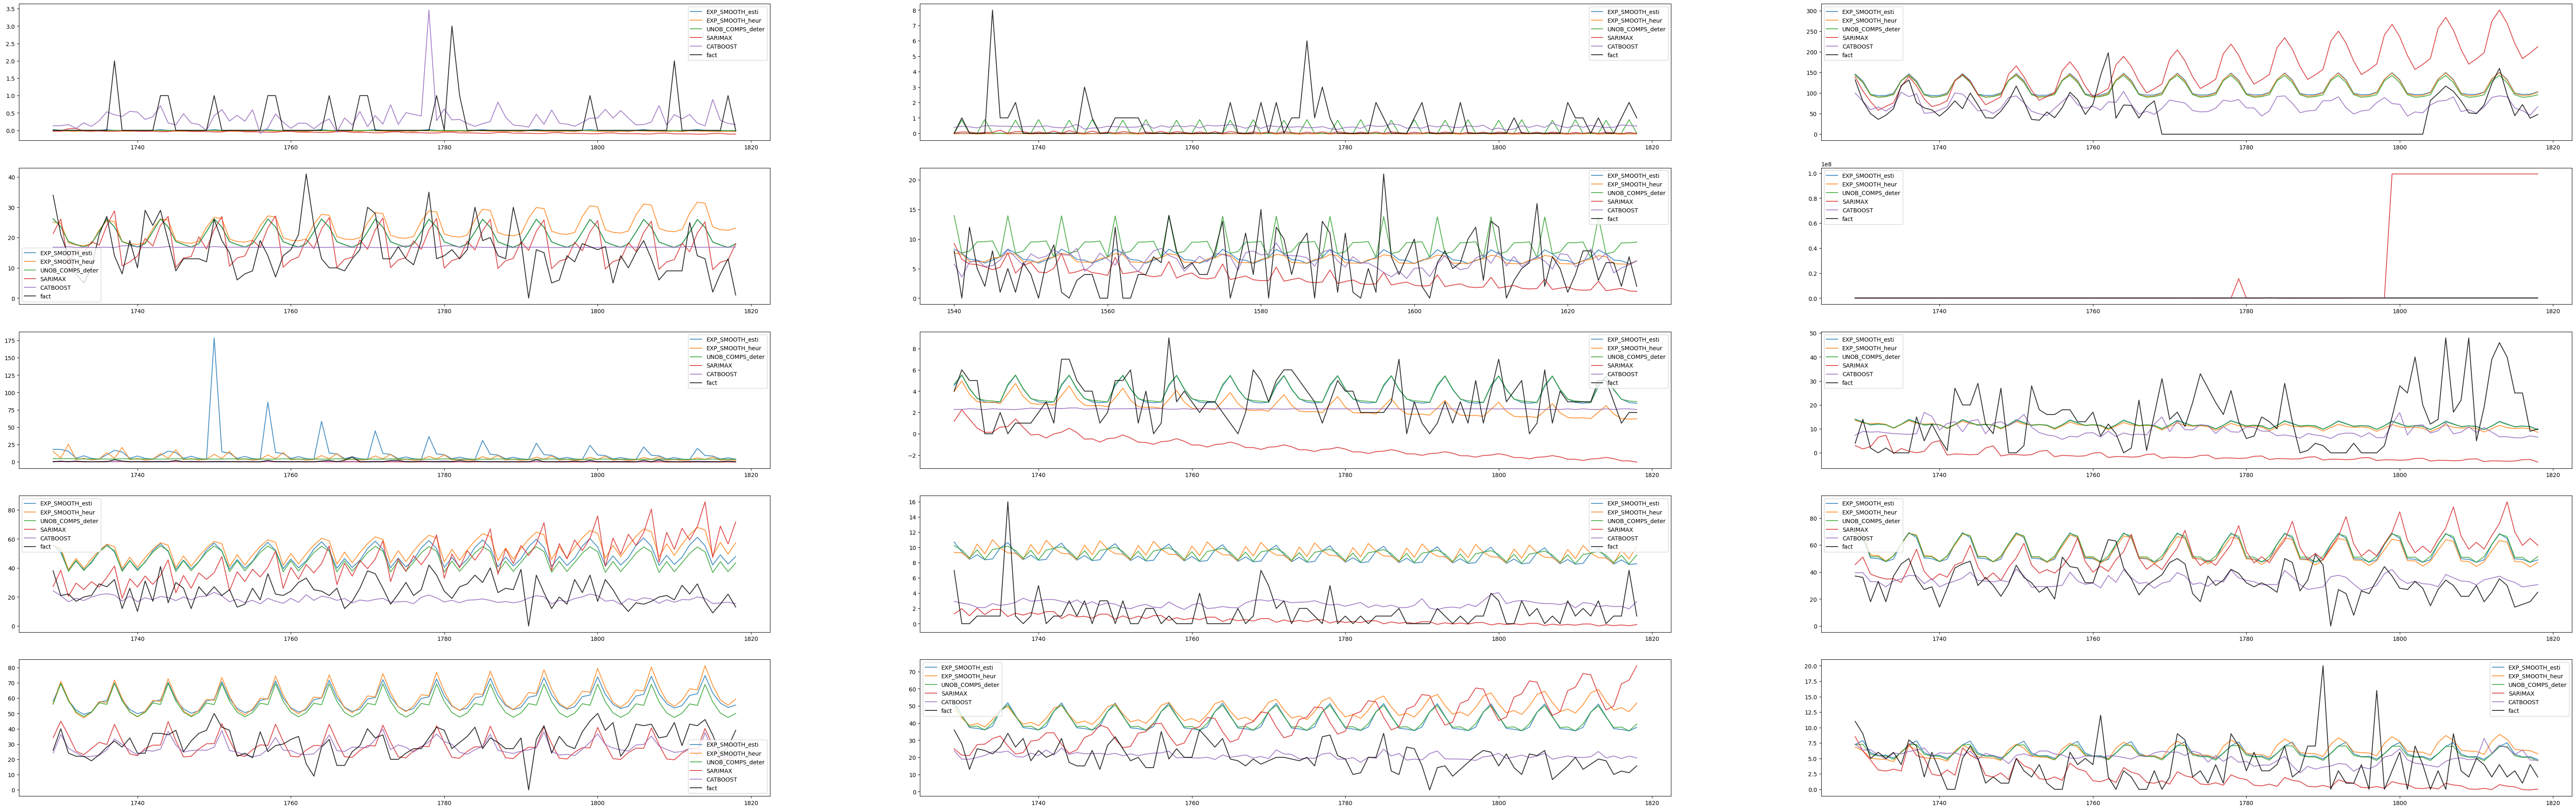

In [22]:
SOLUTION.scoring_predicts()

Выведем победителей:

In [23]:
SOLUTION.print_best()

Результаты по week:
STORE_1_064(0) best: UNOB_COMPS_deter (0.00027871554507918894)
STORE_1_065(1) best: EXP_SMOOTH_esti (0.01975358545448458)
STORE_1_090(2) best: CATBOOST (10.205502733257369)
STORE_1_252(3) best: CATBOOST (6.764383316040039)
STORE_1_325(4) best: SARIMAX (3.2964383873177043)
STORE_1_339(5) best: CATBOOST (1.088846912801225)
STORE_1_376(6) best: CATBOOST (0.46293059018499194)
STORE_1_546(7) best: EXP_SMOOTH_esti (0.9943642320812884)
STORE_1_547(8) best: SARIMAX (1.8041935957355784)
STORE_1_555(9) best: CATBOOST (2.506119142298978)
STORE_1_584(10) best: SARIMAX (1.0272767640733393)
STORE_1_586(11) best: CATBOOST (3.718457040660695)
STORE_1_587(12) best: CATBOOST (2.2133912587111837)
STORE_1_714(13) best: CATBOOST (5.095948234662615)
STORE_1_727(14) best: EXP_SMOOTH_esti (0.9465579961667645)
Результаты по month:
STORE_1_064(0) best: UNOB_COMPS_deter (0.0008008040385000248)
STORE_1_065(1) best: EXP_SMOOTH_esti (0.008562945166720515)
STORE_1_090(2) best: CATBOOST (14.348657

Посмотреть полный скоринг по предметы и периоду:

In [24]:
SOLUTION.scoring_results[SOLUTION.items[0]]["week"]

mean    median    quan75    quan95       std  \
EXP_SMOOTH_esti   0.014552  0.016843  0.020340  0.023979  0.009337   
EXP_SMOOTH_heur   0.017775  0.020764  0.023724  0.028720  0.009913   
UNOB_COMPS_deter  0.000300  0.000279  0.000330  0.000358  0.000041   
SARIMAX           0.029431  0.023777  0.036900  0.052049  0.015074   
CATBOOST          0.156255  0.132635  0.191828  0.257897  0.071519   

                            no_stationary         is_stationary  \
EXP_SMOOTH_esti    5.302230782309191e-05✅                  0.1✅   
EXP_SMOOTH_heur    0.0034101932761461894✅                  0.1✅   
UNOB_COMPS_deter  5.6638056451068736e-30✅  0.08715580318269615✅   
SARIMAX              0.11653121171247122❌                  0.1✅   
CATBOOST             0.00454557542142458✅  0.04166666666666642❌   

                 no_autocorrelation   is_homoscedasticity  \
EXP_SMOOTH_esti                0.0✅    0.950250567216144✅   
EXP_SMOOTH_heur                0.0✅   0.8140810436747566✅   
UNOB_COMPS_deter               1.0❌  0.01028070586797339❌   
SARIMAX                        0.0✅   0.6045342634083262✅   
CATBOOST                       0.0✅  0.17475993991882133✅   

                             is_mean_zero            is_normality  
EXP_SMOOTH_esti         0.20824085987201✅    0.30624980570882543✅  
EXP_SMOOTH_heur     0.003177629544877848❌     0.7438517037439398✅  
UNOB_COMPS_deter  1.2559209198026182e-06❌    0.09780226628285332✅  
SARIMAX               0.9790476428319346✅  0.0032181625480666182❌  
CATBOOST           0.0011718384066571619❌     0.8376980303251946✅

Лучше всего себя показывает CatBoost, его и сохраняем.

In [24]:
SOLUTION.save_models("../models/", False, False, False, True)